In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

## Load data

In [4]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [5]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [6]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

In [7]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

## Hybrid Model

Batch gradient descent

In [18]:
def batch_gd(season_scores, skater_order=False,
             init_value=0.5, init_random=False, init_seed=42,
             alpha=0.001, n_iter=1000, log_iter=False, log_every=10, additional_iter=range(1, 10)):
    season_pivot = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
    if skater_order is not False:
        season_pivot = season_pivot.loc[skater_order]
    skater_names = list(season_pivot.index)
    event_names = list(season_pivot.columns)    
    true_scores = season_pivot.values
    
    if init_random:
        random_state = np.random.RandomState(init_seed)
        skater_scores = random_state.random_sample(len(skater_names))
        event_scores = random_state.random_sample(len(event_names))
        baseline = random_state.random_sample()
    else:
        skater_scores = np.full(len(skater_names), init_value)
        event_scores = np.full(len(event_names), init_value)
        baseline = init_value
    
    skater_scores_log = []
    event_scores_log = []
    baseline_log = []
    rmse_log = []
    diff_log = []
    iter_log = []
    
    for i in range(n_iter):
        predicted_scores = np.outer(skater_scores, event_scores) + baseline
        diff = predicted_scores - true_scores
        
        # Log intermediate values at certain iterations
        if log_iter and (i%log_every==0 or (i in additional_iter)):
            iter_log.append(i)
            skater_scores_log.append(pd.Series(skater_scores, index=skater_names))
            event_scores_log.append(pd.Series(event_scores, index=event_names))
            baseline_log.append(baseline)
            diff_log.append(diff)
            rmse = np.sqrt(np.nanmean(diff**2))
            rmse_log.append(rmse)
        
        # Calculate parameter gradients
        skater_gradients = np.nansum(diff * event_scores, axis=1)
        event_gradients = np.nansum(diff.T * skater_scores, axis=1)
        baseline_gradient = np.nansum(diff)
        
        # Update parameters
        event_scores = event_scores - alpha * event_gradients
        skater_scores = skater_scores - alpha * skater_gradients
        baseline = baseline - alpha * baseline_gradient
             
    log = [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, diff_log, rmse_log]
    skater_scores = pd.Series(skater_scores, index=skater_names).sort_values(ascending=False)
    event_scores = pd.Series(event_scores, index=event_names).sort_values(ascending=False)
    
    if log_iter:
        return baseline, event_scores, skater_scores, log
    else:
        return baseline, event_scores, skater_scores

Animation

In [19]:
# Final results after 200 iterations
final_baseline, final_event_scores, final_skater_scores = batch_gd(season_scores, init_random=True, alpha=0.001, n_iter=200)

In [20]:
# Logged results during 200 iterations, using skater ranking from the final 200th iteration (only for asthetic reason)
baseline, event_scores, skater_scores, [iter_log, true_scores, skater_names, event_names, skater_scores_log, event_scores_log, baseline_log, diff_log, rmse_log] = batch_gd(season_scores, 
skater_order=final_skater_scores.index[::-1],
init_random=True, alpha=0.001, n_iter=201,
log_iter=True, log_every=10, additional_iter=list(range(1, 10)))

rankings_log = [return_ranking(skater_scores, world_scores)[0] for skater_scores in skater_scores_log]
world_ranking = return_ranking(skater_scores_log[0], world_scores)[1]
taus_log = [calculate_kendall_tau(season_ranking, world_ranking, verbose=False) for season_ranking in rankings_log]

In [22]:
def update(i, fig, ax1, ax2, ax3, ax4):
    print(i)
    
    fig.suptitle(f'Iteration {iter_log[i]}', fontsize=20)
    diff = diff_log[i]
    event_scores = event_scores_log[i].values
    event_scores = event_scores.reshape(1, len(event_scores))
    ax1.imshow(-diff, cmap='coolwarm', vmin=-30, vmax=30)
    ax1.set_yticklabels(['{0:.2f}'.format(score) for score in skater_scores_log[i]], fontsize=10)
    ax1.set_xticklabels(['{0:.2f}'.format(score) for score in event_scores_log[i]], fontsize=10, rotation=90) 
    baseline_text.set_text('{0:.2f}'.format(baseline_log[i]))
    
    if i == 0:
        ax2.plot(iter_log[i], rmse_log[i], '.', color='tab:brown', clip_on=False)
    if i >= 1:
        ax2.plot(iter_log[i-1:i+1], rmse_log[i-1:i+1], '.-', color='tab:brown', clip_on=False)
        
    if i == 0:
        ax3.plot(iter_log[i], taus_log[i], '.', color='tab:orange', clip_on=False)
    if i >= 1:
        ax3.plot(iter_log[i-1:i+1], taus_log[i-1:i+1], '.-', color='tab:orange', clip_on=False)
        
    ax4.lines = []
    ax4.texts = []
    cmap = mpl.cm.get_cmap('winter')
    predicted_ranking = rankings_log[i]
    n_skaters = len(world_ranking)
    for index, skater in enumerate(world_ranking):
        # For each skater in world ranking, query his rank in the predicted ranking
        world_rank = index + 1
        predicted_rank = predicted_ranking.index(skater) + 1
        
        # Get y-positions for each rank: lower rank number (1) means higher y-position (on top)
        world_index = n_skaters - world_rank
        predicted_index = n_skaters - predicted_rank
        
        # Get color tuple for each skater in the world ranking
        world_color = cmap(world_rank/(n_skaters*1.1))
        
        # Plot connecting lines between two rankings
        ax4.plot([0, 1], [predicted_index, world_index], 'o-', color=world_color)
        
        # Plot text on both sides
        ax4.text(1.1, world_index, f'{world_rank} {skater}', ha='left', va='center', color=world_color, fontsize=9)
        ax4.text(-0.1, predicted_index, f'{skater} {predicted_rank}', ha='right', va='center', color=world_color, fontsize=9)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


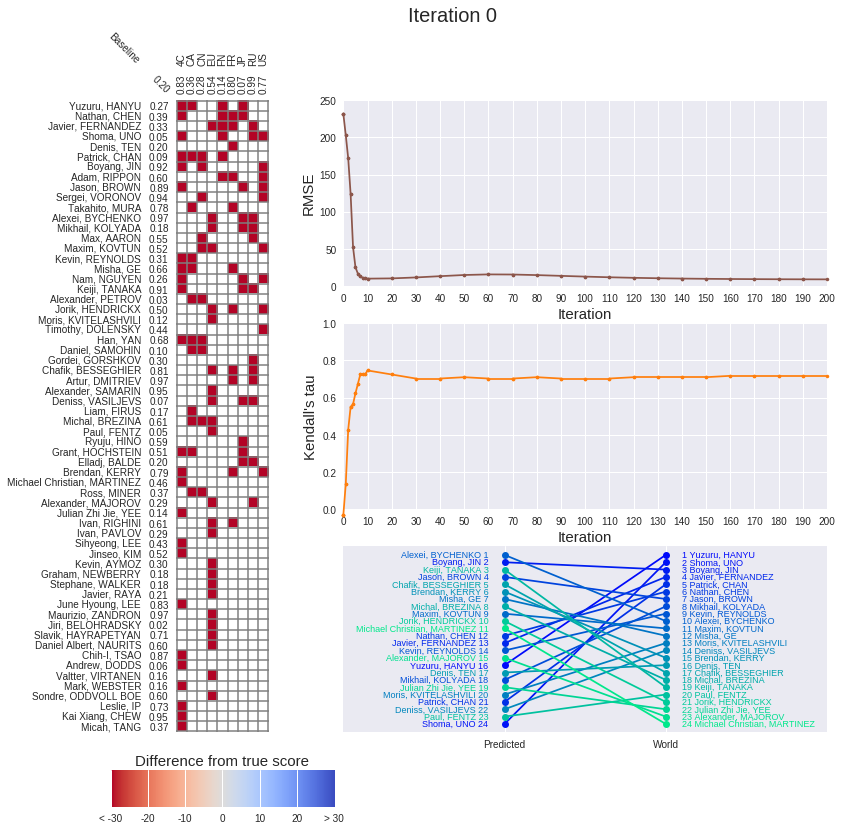

In [23]:
fig = plt.figure(figsize=(13, 13))
grid = plt.GridSpec(10, 3, wspace=0, hspace=1)

ax1 = fig.add_subplot(grid[:-1, 0])
for i, skater in enumerate(skater_names):
    ax1.text(x=-4, y=i-0.3, s=skater, ha='right')
for i, event in enumerate(event_names):
    ax1.text(x=i-0.5, y=len(skater_names)+3, s=event, rotation=90, va='bottom')
ax1.text(x=-4, y=len(skater_names)+3, s='Baseline', rotation=-45, va='bottom', ha='right')
baseline_text = ax1.text(x=-1, y=len(skater_names)+0.1, s='', rotation=-45, va='bottom', ha='right')

ax1.set_xticks(np.arange(-.5, len(event_names), 1), minor=True)
ax1.set_yticks(np.arange(-.5, len(skater_names), 1), minor=True)
ax1.grid(which='minor', color='tab:gray', ls='-', lw=1.5)
ax1.grid(None, which='major')
ax1.set_xlim(-0.6, len(event_names)-0.4)
ax1.set_xticks(range(len(event_names)))
ax1.xaxis.tick_top()
ax1.set_ylim(-0.6, len(skater_names)-0.45)
ax1.set_yticks(range(len(skater_names)))
ax1.set_facecolor('white')

ax2 = fig.add_subplot(grid[:3, 1:])
ax2.set_xlim(0, iter_log[-1])
ax2.set_xticks(range(0, iter_log[-1]+1, 10))
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylim(0, 250)
ax2.set_ylabel('RMSE', fontsize=15)

ax3 = fig.add_subplot(grid[3:6, 1:])
ax3.set_xlim(0, iter_log[-1])
ax3.set_xticks(range(0, iter_log[-1]+1, 10))
ax3.set_xlabel('Iteration', fontsize=15)
ax3.set_ylim(0, 1)
ax3.set_ylabel("Kendall's tau", fontsize=15)

ax4 = fig.add_subplot(grid[6:9, 1:])
ax4.set_xlim(-1, 2)
ax4.set_xticks([0, 1])
ax4.set_xticklabels(['Predicted', 'World'])
ax4.set_yticks([])

ax5 = fig.add_subplot(grid[9, 0])
cmap = plt.cm.get_cmap('coolwarm')
colors = cmap(np.arange(cmap.N))
colors = np.flip(colors, axis=0)
ax5.imshow([colors], extent=[-30, 30, 0, 10])
ax5.xaxis.set_label_position('top') 
ax5.set_xlabel('Difference from true score', fontsize=15)
ax5.set_xticklabels(['< -30', '-20', '-10', '0', '10', '20', '> 30'])
ax5.set_yticks([])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax1, ax2, ax3, ax4), 
                     frames=len(iter_log), interval=500, repeat_delay=3000)

anim.save('viz/diff_anim.gif', writer='imagemagick')

### Comparison with other models

In [109]:
baseline, event_scores, skater_scores = batch_gd(season_scores, init_random=True, alpha=0.001, n_iter=10000)

In [125]:
season_avg = pd.read_csv('data/season_avg.csv', index_col=0, squeeze=True, header=None)
season_avg.head()

0
Yuzuru, HANYU        290.5350
Javier, FERNANDEZ    285.4925
Shoma, UNO           283.7425
Nathan, CHEN         281.0050
Patrick, CHAN        270.3500
Name: 1, dtype: float64

In [ ]:
df_compare_hyb = pd.merge(season_scores, event_scores.to_frame(name='event_score'), how='left', left_on='event', right_index=True)
df_compare_hyb = pd.merge(df_compare_hyb, skater_scores.to_frame(name='skater_score'), how='left', left_on='name', right_index=True)
df_compare_hyb = pd.merge(df_compare_mul, season_avg.to_frame(name='avg'), left_on='name', how='left', right_index=True)
df_compare_hyb['baseline'] = baseline
df_compare_hyb['baseline_event'] = df_compare_mul['baseline'] * df_compare_mul['event_score']
df_compare_hyb['predicted'] = df_compare_mul['baseline'] * df_compare_mul['event_score'] * df_compare_mul['skater_score']
df_compare_hyb['residual'] = df_compare_mul['predicted'] - df_compare_mul['score']
# df_compare_mul.to_csv('data/df_compare_mul.csv')

### Refactor

In [60]:
class Hybrid(Linear):
    def __init__(self, alpha, n_factors, lambda_reg=0):
        super().__init__(lambda_reg)
        self.alpha = alpha
        self.n_factors = n_factors
        
    def predict_season_scores(self, season_scores):
        predicted_score_table = pd.DataFrame(self.skater_scores.values @ self.event_scores.values.T + self.baseline,
                                            index=self.skater_scores.index,
                                            columns=self.event_scores.index)
        
        predicted_score_stacked = predicted_score_table.stack()
        season_skater_event_index = season_scores.set_index(['name', 'event']).index
        self.predicted_season_scores = predicted_score_stacked.loc[season_skater_event_index].values
        
    def fit(self, season_scores, n_iter, seed=42, fixed_baseline=False, verbose=False):
        if verbose:
            logging.disable(logging.NOTSET)
        else:
            logging.disable(logging.DEBUG)
        season_table = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
        skater_names = list(season_table.index)
        event_names = list(season_table.columns)

        true_scores = season_table.values
        random_state = np.random.RandomState(seed=seed)
        self.skater_scores = random_state.random_sample((len(skater_names), self.n_factors))
        self.event_scores = random_state.random_sample((len(event_names), self.n_factors))
        self.baseline = season_scores['score'].mean() if fixed_baseline else 0.5

        self.rmses = []
        
        for iteration in range(n_iter):
            logging.debug(f'iteration: {iteration}')
            diff = self.skater_scores @ self.event_scores.T + self.baseline - true_scores
            
            for i in range(self.n_factors):
                logging.debug(f'i: {i}')
                if not fixed_baseline:
                    baseline_gradient = np.nansum(diff)
                    self.baseline = self.baseline - self.alpha * baseline_gradient
                    
                logging.debug(f'skater_scores before\n{self.skater_scores}')
                logging.debug(f'event_scores before\n{self.event_scores}')                               
                skater_gradients = np.nansum(diff * self.event_scores[:, i], axis=1) + self.lambda_reg * self.skater_scores[:, i]
                event_gradients = np.nansum(diff.T * self.skater_scores[:, i], axis=1) + self.lambda_reg * self.event_scores[:, i] 
                logging.debug(f'skater_gradients\n{skater_gradients}')
                logging.debug(f'event_gradients\n{event_gradients}')
                
                self.skater_scores[:, i] = self.skater_scores[:, i] - self.alpha * skater_gradients
                self.event_scores[:, i] = self.event_scores[:, i] - self.alpha * event_gradients
                logging.debug(f'skater_scores after\n{self.skater_scores}')
                logging.debug(f'event_scores after\n{self.event_scores}')
                
            rmse = np.sqrt(np.nanmean(diff**2))
            self.rmses.append(rmse)

        self.skater_scores = pd.DataFrame(self.skater_scores, index=skater_names)
        self.event_scores = pd.DataFrame(self.event_scores, index=event_names)
        
        self.skater_scores.sort_values(by=0, ascending=False, inplace=True)
        self.event_scores.sort_values(by=0, ascending=False, inplace=True)
        
        self.predict_season_scores(season_scores)

    def evaluate_rmse_over_years(self, years, season_df, world_df, **kwargs):
        rmses = []
        for year in years:
            season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
            self.fit(season_scores, **kwargs)
            rmse = self.evaluate_rmse(season_scores)
            rmses.append(rmse)
        return pd.DataFrame({'year': years, 'rmse': rmses}).sort_values(by='year')

### Single latent factor

In [146]:
hybrid = Hybrid(alpha=0.001, n_factors=1, lambda_reg=10)
hybrid.fit(season_scores, n_iter=1000, seed=42)

In [147]:
hybrid.skater_scores.head()

,0
"Yuzuru, HANYU",9.311300
"Nathan, CHEN",7.737974
"Javier, FERNANDEZ",7.563217
"Shoma, UNO",7.491667
"Patrick, CHAN",6.425772


In [148]:
hybrid.event_scores.head()

,0
EU,11.307682
4C,10.576126
RU,9.723993
CN,9.441479
FR,8.758149


Train over all years in training set

In [149]:
hybrid = Hybrid(alpha=0.001, n_factors=1, lambda_reg=10)
hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_train, world_train, 
                    n_iter=1000, seed=42)
hybrid_train_eval

,year,rmse,tau,conc,pairs
0,2005,9.608030,0.628571,171,210
1,2006,9.165213,0.620553,205,253
2,2007,7.982004,0.644928,227,276
3,2009,8.743461,0.601449,221,276
4,2010,10.162420,0.705628,197,231
5,2012,8.995002,0.612648,204,253
6,2013,9.202840,0.644269,208,253
7,2014,9.472834,0.828571,192,210
8,2016,11.426683,0.688406,233,276
9,2017,9.541887,0.688406,233,276


Regularization

In [73]:
for lambda_reg in [0, 0.1, 1, 2, 5, 10]:
    hybrid = Hybrid(lambda_reg=lambda_reg, alpha=0.001, n_factors=1)
    hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_train, world_train, 
                                                   n_iter=1000, seed=42)
    print(lambda_reg, hybrid_train_eval['rmse'].mean(), hybrid_train_eval['tau'].mean())

0 8.798979360662049 0.6695765104460756
0.1 8.799759095040118 0.670301148127235


KeyboardInterrupt: 

In [ ]:
hybrid = Hybrid(alpha=0.001, n_factors=1, lambda_reg=1)
hybrid.fit(season_scores, n_iter=1000, seed=42)
hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_train, world_train, 
                    n_iter=1000, seed=42)
hybrid_train_eval

In [ ]:
for lambda_reg in [0, 1]:
    hybrid = Hybrid(lambda_reg=lambda_reg, alpha=0.001, n_factors=1)
    hybrid_test_eval = hybrid.evaluate_over_years(test_years, season_test, world_test,
                                                  n_iter=1000, seed=42)
    print(lambda_reg, hybrid_test_eval['rmse'].mean(), hybrid_test_eval['tau'].mean())

In [ ]:
avg = AverageScore()
avg_test_eval = avg.evaluate_over_years(test_years, season_test, world_test)
avg_test_eval['tau'].mean()

### Multiple latent factors

In [74]:
random_state = np.random.RandomState(seed=42)
f1_years = list(random_state.choice(train_years, 5, replace=False))
f2_years = [year for year in train_years if year not in f1_years]

In [75]:
def get_season_and_world_scores(scores):
    all_season_scores = {}
    all_world_scores = {}

    for year in range(2005, 2020):
        season_scores = scores.loc[(scores['year']==year) & (scores['event']!='WR')].copy()
        world_scores = scores.loc[(scores['year']==year) & (scores['event']=='WR'), ['name', 'score']]
        world_scores = world_scores.set_index('name').squeeze()
        all_season_scores[year] = season_scores
        all_world_scores[year] = world_scores
    return all_season_scores, all_world_scores

In [84]:
all_season_scores, all_world_scores = get_season_and_world_scores(male_scores)

In [126]:
all_normalized_scores = {}
all_pair_diffs = {}

for year in train_years:
    season_scores = all_season_scores[year]
    world_scores = all_world_scores[year]
    hybrid = Hybrid(alpha=0.001, n_factors=5, lambda_reg=10)
    hybrid.fit(season_scores, n_iter=1000, seed=42)    
    hybrid_scores = hybrid.skater_scores
    
    normalized_scores = (hybrid_scores - hybrid_scores.mean(axis=0)) / hybrid_scores.std(axis=0)
    normalized_scores = normalized_scores.reindex(world_scores.index).dropna()
    all_normalized_scores[year] = normalized_scores
    
    pair_diffs = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normalized_scores.values, 2)))
    all_pair_diffs[year] = pair_diffs

In [131]:
X_train = np.vstack((all_pair_diffs[year] for year in f2_years))
y_train = np.full(len(X_train), 1)
n_coefs = X_train.shape[1]

In [132]:
log = BatchLogistic(theta=np.full(n_coefs, 0.5), alpha=0.001, lambda_reg=10)
log.fit(X_train, y_train, n_iter=1000)
log.theta

array([0.37336036, 0.80010816, 0.25238218, 0.38409724, 0.50886353])

In [133]:
f1_taus = []
for year in f1_years:
    print(year)
    normalized_scores = all_normalized_scores[year]
    combined_scores =  pd.Series(normalized_scores @ log.theta, index=normalized_scores.index)
    combined_ranking, world_ranking = return_ranking(combined_scores, all_world_scores[year])
    f1_taus.append(calculate_kendall_tau(combined_ranking, world_ranking))
    
print(np.array(f1_taus).mean())

2016
There are 237 concordant_pairs out of 276 pairs
2006
There are 205 concordant_pairs out of 253 pairs
2012
There are 199 concordant_pairs out of 253 pairs
2005
There are 173 concordant_pairs out of 210 pairs
2014
There are 191 concordant_pairs out of 210 pairs
0.6755467720685113


In [134]:
f2_taus = []
for year in f2_years:
    print(year)
    normalized_scores = all_normalized_scores[year]
    combined_scores =  pd.Series(normalized_scores @ log.theta, index=normalized_scores.index)
    combined_ranking, world_ranking = return_ranking(combined_scores, all_world_scores[year])
    f2_taus.append(calculate_kendall_tau(combined_ranking, world_ranking))
    
print(np.array(f2_taus).mean())

2007
There are 228 concordant_pairs out of 276 pairs
2009
There are 223 concordant_pairs out of 276 pairs
2010
There are 195 concordant_pairs out of 231 pairs
2013
There are 202 concordant_pairs out of 253 pairs
2017
There are 226 concordant_pairs out of 276 pairs
0.638189346884999


### Refactoring

In [135]:
class HybridLog:
    def __init__(self, n_factors, hybrid_lambda,
              hybrid_alpha=0.001, hybrid_iter=1000, hybrid_seed=42,
              log_alpha=0.001, log_iter=1000):
        self.n_factors = n_factors
        self.hybrid_lambda = hybrid_lambda
        self.hybrid_alpha = hybrid_alpha
        self.hybrid_iter = hybrid_iter
        self.hybrid_seed = hybrid_seed
        self.log_alpha = log_alpha
        self.log_iter = log_iter

    
    def fit_hybrid(self, season_df, world_df, train_years):
        # Train hybrid model on each training years to get latent factor values
        all_pair_diffs = {}
        for year in train_years:
            season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
            hybrid = Hybrid(alpha=self.hybrid_alpha, n_factors=self.n_factors, lambda_reg=self.hybrid_lambda)
            hybrid.fit(season_scores, n_iter=self.hybrid_iter, seed=self.hybrid_seed)
            hybrid_skater_scores = hybrid.skater_scores

            normalized_scores = (hybrid_skater_scores - hybrid_skater_scores.mean(axis=0)) / hybrid_skater_scores.std(axis=0)
            normalized_scores = normalized_scores.reindex(world_scores.index).dropna()

            pair_diffs = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normalized_scores.values, 2)))
            all_pair_diffs[year] = pair_diffs

        # Train logistic regression on pairwise differences of latent factor values
        self.X_train = np.vstack((all_pair_diffs[year] for year in train_years))
        self.y_train = np.full(len(self.X_train), 1)
    
    
    def fit_log(self, log_lambda):
        log = BatchLogistic(theta=np.full(self.n_factors, 0.5), alpha=self.log_alpha, 
                            lambda_reg=log_lambda)
        log.fit(self.X_train, self.y_train, n_iter=self.log_iter)
        self.log_coefs = log.theta

    
    def predict(self, season_scores):
        hybrid = Hybrid(alpha=self.hybrid_alpha, n_factors=self.n_factors, lambda_reg=self.hybrid_lambda)
        hybrid.fit(season_scores, n_iter=self.hybrid_iter, seed=self.hybrid_seed)    
        hybrid_skater_scores = hybrid.skater_scores

        normalized_scores = (hybrid_skater_scores - hybrid_skater_scores.mean(axis=0)) / hybrid_skater_scores.std(axis=0)    
        combined_scores = pd.Series(normalized_scores @ self.log_coefs, index=normalized_scores.index)
        combined_scores.sort_values(ascending=False, inplace=True)
        return combined_scores


In [136]:
def average_kendall_tau(hybridlog, years, season_df, world_df):
    kendall_taus = []
    for year in years:
        season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
        combined_scores = hybridlog.predict(season_scores)
        combined_ranking, world_ranking = return_ranking(combined_scores, world_scores)
        kendall_tau = calculate_kendall_tau(combined_ranking, world_ranking, verbose=False)
        kendall_taus.append(kendall_tau)

    return np.array(kendall_taus).mean()


def get_tau_train_val(season_df, world_df, train_years, val_years,
                      hybridlog, log_lambda):
    hybridlog.fit_log(log_lambda)
    avg_tau_train = average_kendall_tau(hybridlog, train_years, season_df, world_df)
    avg_tau_val = average_kendall_tau(hybridlog, val_years, season_df, world_df)
    return avg_tau_train, avg_tau_val

In [139]:
n_factors = []
hybrid_lambdas = []
log_lambdas = []
f1_tau_trains = []
f1_tau_vals = []
f2_tau_trains = []
f2_tau_vals = []

n_iter = 1000
for n_factor in [1, ]:
    for hybrid_lambda in [10]:
        n_factors.append(n_factor)
        hybrid_lambdas.append(hybrid_lambda)

        # Train hybrid models on each fold
        hybridlog1 = HybridLog(n_factors=n_factor, hybrid_lambda=hybrid_lambda,
                            hybrid_alpha=0.001, hybrid_iter=n_iter, hybrid_seed=42,
                            log_alpha=0.001, log_iter=n_iter)
        hybridlog1.fit_hybrid(season_male, world_male, f1_years)

        hybridlog2 = HybridLog(n_factors=n_factor, hybrid_lambda=hybrid_lambda,
                            hybrid_alpha=0.001, hybrid_iter=n_iter, hybrid_seed=42,
                            log_alpha=0.001, log_iter=n_iter)
        hybridlog2.fit_hybrid(season_male, world_male, f2_years)

      # Train log models on each fold and evaluate kendall tau
    for log_lambda in [10]:
        print(f'n_factor: {n_factor}, hybrid_lambda: {hybrid_lambda}, log_lambda: {log_lambda}')
        log_lambdas.append(log_lambda)
        f1_tau_train, f1_tau_val = get_tau_train_val(season_male, world_male,
                                                     f1_years, f2_years,
                                                     hybridlog1, log_lambda)
        f2_tau_train, f2_tau_val = get_tau_train_val(season_male, world_male,
                                                     f2_years, f1_years,
                                                     hybridlog2, log_lambda)
        print(f'f1_train: {f1_tau_train}, f1_val: {f1_tau_val}, f2_train: {f2_tau_train}, f2_val: {f2_tau_val}')
        f1_tau_trains.append(f1_tau_train)
        f1_tau_vals.append(f1_tau_val)
        f2_tau_trains.append(f2_tau_train)
        f2_tau_vals.append(f2_tau_val)

n_factor: 1, hybrid_lambda: 10, log_lambda: 10
There are 233 concordant_pairs out of 276 pairs
There are 205 concordant_pairs out of 253 pairs
There are 204 concordant_pairs out of 253 pairs
There are 171 concordant_pairs out of 210 pairs
There are 192 concordant_pairs out of 210 pairs
There are 227 concordant_pairs out of 276 pairs
There are 221 concordant_pairs out of 276 pairs
There are 197 concordant_pairs out of 231 pairs
There are 208 concordant_pairs out of 253 pairs
There are 233 concordant_pairs out of 276 pairs
There are 227 concordant_pairs out of 276 pairs
There are 221 concordant_pairs out of 276 pairs
There are 197 concordant_pairs out of 231 pairs
There are 208 concordant_pairs out of 253 pairs
There are 233 concordant_pairs out of 276 pairs
There are 233 concordant_pairs out of 276 pairs
There are 205 concordant_pairs out of 253 pairs
There are 204 concordant_pairs out of 253 pairs
There are 171 concordant_pairs out of 210 pairs
There are 192 concordant_pairs out of 210

In [142]:
comparisons = pd.DataFrame({'n_factor': n_factors, 'hybrid_lambda': hybrid_lambdas, 'log_lambda': log_lambdas,
'f1_tau_train': f1_tau_trains, 'f1_tau_val': f1_tau_vals,
'f2_tau_train': f2_tau_trains, 'f2_tau_val': f2_tau_vals})
comparisons

,n_factor,hybrid_lambda,log_lambda,f1_tau_train,f1_tau_val,f2_tau_train,f2_tau_val
0,1,10,10,0.67575,0.656936,0.656936,0.67575


In [153]:
hybrid_train_eval.loc[hybrid_train_eval['year'].isin(f2_years), 'tau'].mean()

0.656935817805383